## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import json
from mongoengine import connect
from hatespeech_models import Tweet, Article

with open("../data/coronavirus-argentina-v2.json") as f:
    all_articles = json.load(f)

In [2]:
articles = [art for art in all_articles if len(art["comments"]) >= 20]

print(len(articles))


6519


In [3]:
sum(len(art["comments"]) for art in articles)

658976

In [4]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


<AxesSubplot:>

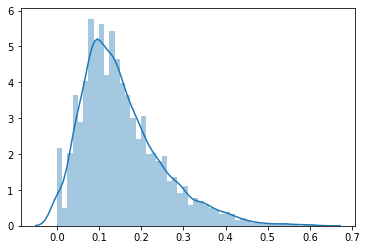

In [5]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

In [6]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

In [7]:
from contextualized_topic_models.models.ctm import CTM
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file
from contextualized_topic_models.datasets.dataset import CTMDataset


In [8]:
import torch

torch.cuda.device_count()

2

In [9]:
import spacy
from tqdm.auto import tqdm
import scipy

nlp = spacy.load("es", disable=["parser", "ner"])

class MyTextHandler:

    def __init__(self):
        self.vocab_dict = {}
        self.vocab = []
        self.index_dd = None
        self.idx2token = None
        self.bow = None

    def prepare(self, articles):
        indptr = [0]
        indices = []
        data = []
        vocabulary = {}

        for art in tqdm(articles):
            for term in nlp(art["title"]):
                token = term.string
                index = vocabulary.setdefault(token, len(vocabulary))
                indices.append(index)
                data.append(1)
            indptr.append(len(indices))

        self.vocab_dict = vocabulary
        self.vocab = list(vocabulary.keys())
        self.idx2token = {v: k for (k, v) in self.vocab_dict.items()}
        self.bow = scipy.sparse.csr_matrix((data, indices, indptr), dtype=int)

In [10]:
handler = MyTextHandler()
handler.prepare(hateful_articles) # create vocabulary and training data


In [11]:
from sentence_transformers import SentenceTransformer

transformer_name = "distiluse-base-multilingual-cased"

sentence_encoder = SentenceTransformer(transformer_name)


In [12]:
import numpy as np

encoded_articles = sentence_encoder.encode([art["title"] for art in hateful_articles])

In [13]:
encoded_articles.shape

(3399, 512)

In [26]:
# generate BERT data
training_bert = encoded_articles

training_dataset = CTMDataset(handler.bow, training_bert, handler.idx2token)

ctm = CTM(input_size=len(handler.vocab), bert_input_size=512, inference_type="contextual", n_components=20)

ctm.fit(training_dataset) # run the mode

Settings: 
               N Components: 20
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.95
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None
Epoch: [1/100]	Samples: [3399/339900]	Train Loss: 186.7672217184742	Time: 0:00:01.961114
Epoch: [2/100]	Samples: [6798/339900]	Train Loss: 183.87073773852373	Time: 0:00:02.000955
Epoch: [3/100]	Samples: [10197/339900]	Train Loss: 181.02763590710273	Time: 0:00:02.093902
Epoch: [4/100]	Samples: [13596/339900]	Train Loss: 178.80702245835172	Time: 0:00:02.085994
Epoch: [5/100]	Samples: [16995/339900]	Train Loss: 176.4486680868339	Time: 0:00:02.053754
Epoch: [6/100]	Samples: [20394/339900]	Train Loss: 175.05254489486796	Time: 0:00:02.041688
Epoch: [7/100]	Samples: [23

KeyboardInterrupt: 

In [27]:

for top in ctm.get_topic_lists(k=100):
    print("\n\n\n")
    
    print(" - ".join(top))





Mauricio  - Macri  - Kirchner  - Florencia  - Cristina  - hija  - Marcelo  - su  - Kirchner - Tinelli  - llegó  - Cuba  - junto  - dura  - libertad  - Jazmín  - Francia - Pérez  - mostró  - Florencia - entrevista - Peña  - responsabilidad - foto  - expropiación  - compartió  - tenso  - Cuba - Acá  - mudó  - durante  - regresó  - viajará  - noticiero  - muelle  - definiciones  - Khalifa - Fabián  - bar - regreso  - Malaspina  - llamar  - publicó  - fama  - atraviesa  - Tinelli - y  - Diego  - hará  - separada - Esquel  - regresa  - habló  - Carrió - cobró  - Hugo  - borrar  - estado  - emocional  - Elisa  - José  - pasado - Flor  - videos  - Maradona - porno  - actuó  - lenguaje  - Recién  - casa  - Mia  - Juliana  - vive  - Gutiérrez - salud - lucha  - al  - Maradona  - cruce  - Padre - último  - visitar  - permita  - une  - mueve  - Morales  - hilos  - crítica  - cumplió  - sus  - Marley  - escuchas  - Chávez  - convocó  - hizo  - Unión  - pileta - recordó  - líderes  - lujosa 




In [20]:

for top in ctm.get_topic_lists(k=100):
    print("\n\n\n")
    
    print(" - ".join(top))





Nicolás  - Lozano  - Verónica  - cómo  - le  - Wiñazki  - aire  - hizo  - burló  - reclamo  - Vero  - su  - usó  - Wiñazki - habló  - dura  - Viale  - situación  - Juana  - durante  - Eugenia  - Vidal  - María  - pidió  - contó  - Flor  - disculpas  - Pais  - refirió  - al  - programa - Ernestina  - hubo  - lucha  - compartió  - distancia  - vivimos - pasado - lenguaje  - humor  - cambió  - "  - inclusivo  - Salazar  - Luciana  - afectó  - Sol  - Malaspina  - Jorge  - ex - Pido  - se  - sobre  - ministra - porno  - Khalifa - líder  - flequillo  - fama  - Mia  - borrar  - burla  - actuó  - cobró  - videos  - clases  - política - Patricia  - fútbol  - descubrir  - Ambrosioni - meses - críticas - revisar  - ahora  - sobrina  - Maduro  - Manuel  - estaba  - pocos  - vuelta  - Lammens  - Jazmín  - test  - imitación  - jugadores - disculpas - atraviesa  - Noche  - retractó  - Era  - piensan  - top  - Mirtha - erróneo  - argumento  - comentario  - darse  - pasar - masivos 




control  - 

In [16]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [17]:
import spacy
from tqdm.auto import tqdm

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


KeyboardInterrupt: 

In [ ]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Sanity check

In [ ]:


filter_words([t.string for t in nlp("Hola , esto. es una prueba e33 ?")])

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("topic_models.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [ ]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [ ]:
import pickle

with open("topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [ ]:
Y = [k.get_coherence() for k in coherence_models.values()]

In [ ]:
import matplotlib.pyplot as plt


plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 12 que es el más chico donde más o menos deja de crecer

In [ ]:
lda_model = lda_models[12]

In [ ]:
from pprint import pprint

pprint(lda_model.print_topics())

In [ ]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

1. Tema "general" (verbos, y otras cosas)
2. Tema "internacional" (China, Trump, avión, extranjero, George Floyd, otros
3. AMBA/CABA: Kicillof, Larreta, Berni: política CABA, AMBA y demás
4. Mujeres y feminismo
5. JxC vs FDT: Macri, Cristina, expropiación, Senado, etc
6. Judiciales/Policiales
7. Conflictos sindicales y económicos: Moyano, pago, grabois, ife, k, camioneros,e tc
8. Notas económicas: dólar, pobreza, silobolsas, default, impuestos, guzmán
9. Salud
10. Conflictos "campo": Vicentín y silobolsas
11. China y su comida?
12. Ruido


In [ ]:
temas = [
    "general",
    "internacional",
    "amba/caba",
    "mujeres",
    "cambiemos vs fdt",
    "judiciales y policiales",
    "sindicales",
    "económicas",
    "salud",
    "Campo conflictos",
    "China comida?",
    "Ruido",
]

len(temas)

In [ ]:
len(corpus), len(hateful_articles)

In [ ]:
num = 3

def display_topics(num):
    print(hateful_articles[num]["title"])
    
    topics = lda_model.get_document_topics(corpus[num])
    
    
    print(" + ".join(f"{temas[idx]} * {porc:.2f}" for idx, porc in topics))


for num in range(len(hateful_articles)):
    print("=" * 80 + '\n\n')
    
    display_topics(num)

In [ ]:
lda_model.get_document_topics()